 *** parameter estimations *********************
Parameters:          ,        p1,        p2,
original values:     ,       0.3,       0.4,
perturbed values:    ,       0.4,      0.45,
optimised values:    ,   0.27822,   0.44506,

Scaled-space cost (each variable normalized by N):
  Baseline:     1000190.890
  Linearized:   479586.260


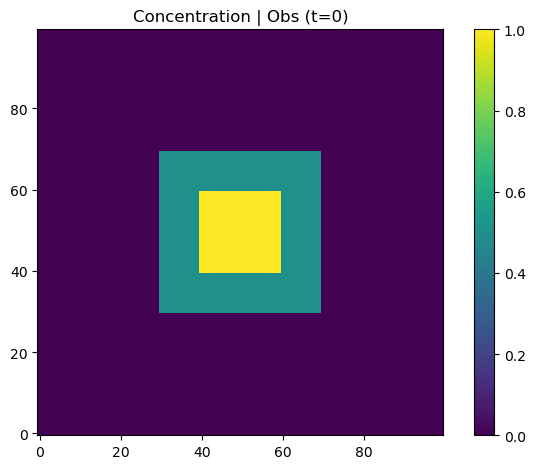

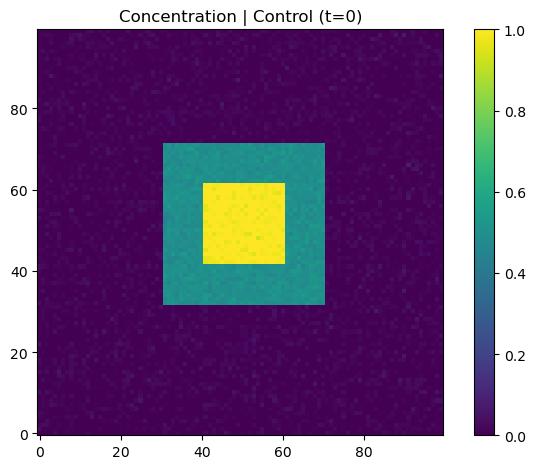

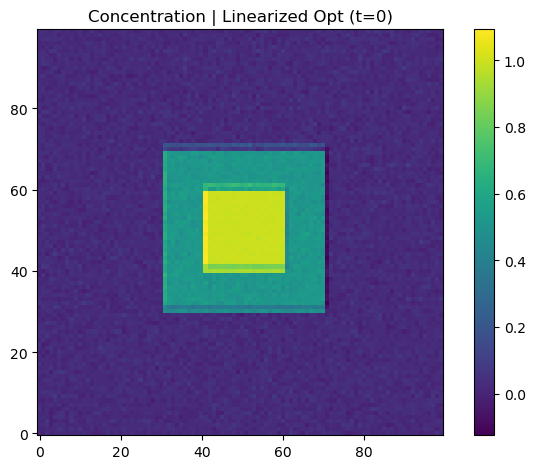

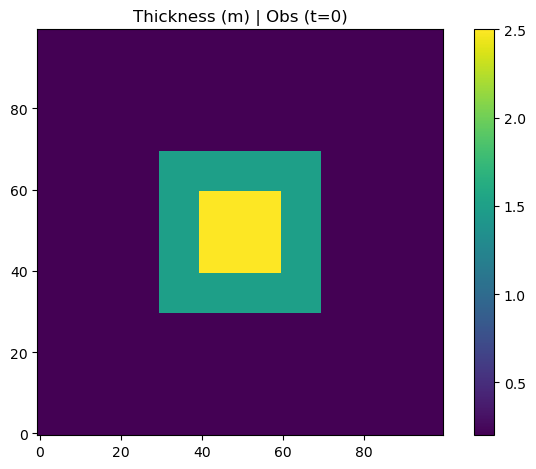

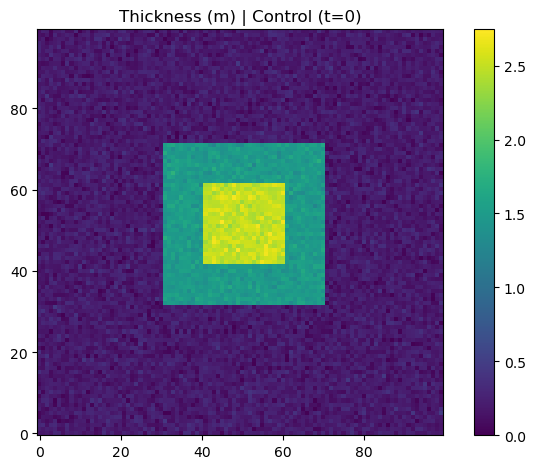

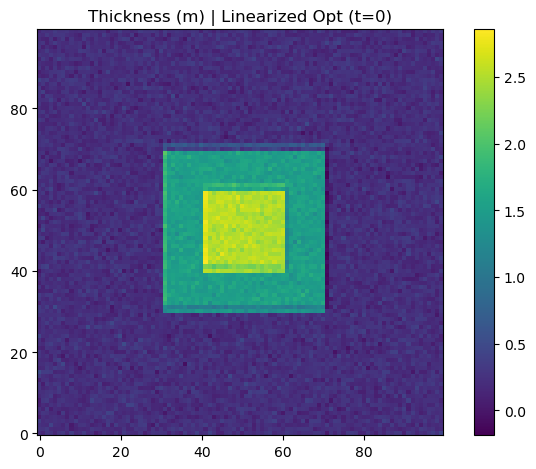

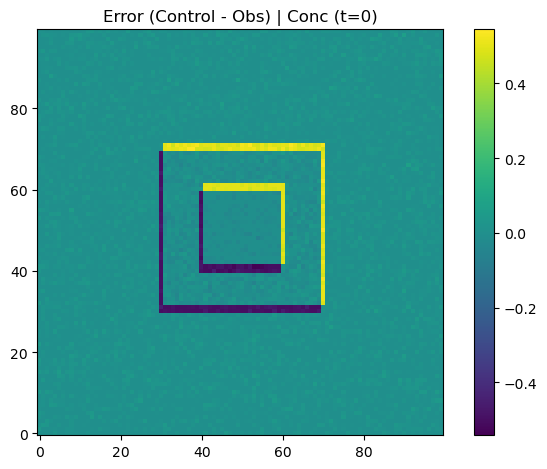

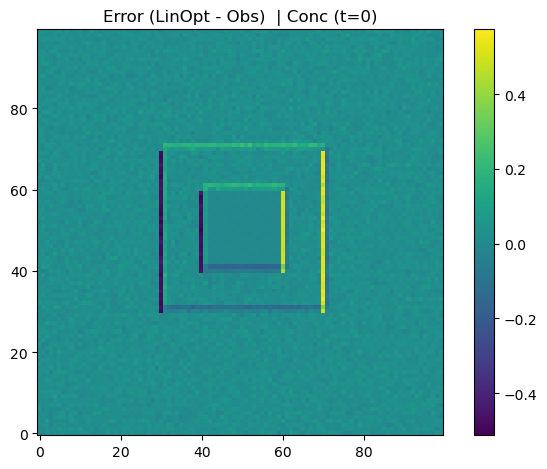

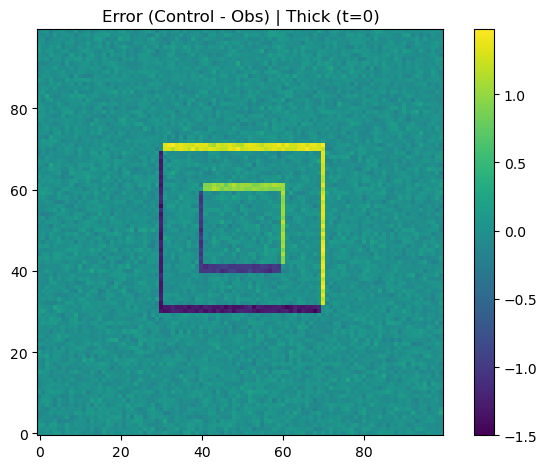

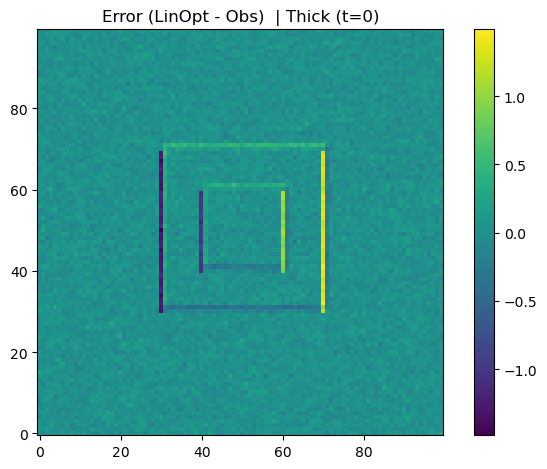

In [4]:
#!/usr/bin/env python3
"""
Green's Function demo (100x100x20) with concentration & thickness,
using *pre-scaling by variable sample size* so each variable has equal weight.

- Observations: simple square patch pattern (conc & thickness)
- Sigma: 0.05 (conc), 0.20 m (thickness)
- Control and 2 perturbed runs: obs + tiny noise; each run's main ice is shifted
  by a couple of grid points in a random direction
- GF solve is done on *scaled* x, y, sigma, and x_pert so each variable's
  contribution is normalized by its number of used points.

Parameters (reported only): [0.3, 0.4]
Perturbation steps: [0.10, 0.05]
"""

import numpy as np
import matplotlib.pyplot as plt
import gf_opt as gf  # expects: calcDataKernel, optimiseGF, costFunction, printParms

# ----------------------------
# Synthetic observations
# ----------------------------
def make_obs_conc(nx=100, ny=100, nt=20):
    """Square concentration: 1.0 core, 0.5 ring, 0 elsewhere; repeated over time."""
    conc2d = np.zeros((nx, ny), dtype=float)
    conc2d[30:70, 30:70] = 0.5    # ring
    conc2d[40:60, 40:60] = 1.0    # full-ice core
    return np.repeat(conc2d[None, :, :], nt, axis=0)  # (t, x, y)

def make_obs_thick(nx=100, ny=100, nt=20):
    """Thickness aligned with concentration: 0.2 (bg), 1.5 (ring), 2.5 (core)."""
    thick2d = np.full((nx, ny), 0.2, dtype=float)
    thick2d[30:70, 30:70] = 1.5
    thick2d[40:60, 40:60] = 2.5
    return np.repeat(thick2d[None, :, :], nt, axis=0)  # (t, x, y)

# ----------------------------
# Helpers
# ----------------------------
def roll2d_field_stack(F, dx, dy):
    """Roll a (t, x, y) stack by (dx, dy) over spatial axes (periodic for demo)."""
    return np.roll(np.roll(F, shift=dx, axis=1), shift=dy, axis=2)

def plot_field(field2d, title):
    plt.figure()
    im = plt.imshow(field2d, origin="lower", interpolation="nearest")
    plt.title(title)
    plt.colorbar(im)
    plt.tight_layout()

# ----------------------------
# Main
# ----------------------------
def main():
    rng = np.random.default_rng(7)

    nx, ny, nt = 100, 100, 20
    Ngrid = nx * ny * nt

    # Observations (unscaled fields for plotting)
    Yc = make_obs_conc(nx, ny, nt)   # conc in [0,1]
    Yh = make_obs_thick(nx, ny, nt)  # thickness in m

    # Sigmas (weights): 5% conc, 0.2 m thickness
    sigma_conc = 0.05
    sigma_thik = 0.20

    # ----------------------------
    # Build CONTROL and PERTURBED runs with small random spatial shifts (±2)
    # ----------------------------
    def small_shift():
        return rng.integers(-2, 3), rng.integers(-2, 3)  # inclusive ±2

    dx0, dy0 = small_shift()      # control shift
    dx1, dy1 = small_shift()      # perturbed #1 shift
    dx2, dy2 = small_shift()      # perturbed #2 shift

    noise_c = 0.02   # concentration noise
    noise_h = 0.08   # thickness noise (meters)

    # Control (baseline)
    Xc = roll2d_field_stack(Yc, dx0, dy0) + rng.normal(0.0, noise_c, size=Yc.shape)
    Xh = roll2d_field_stack(Yh, dx0, dy0) + rng.normal(0.0, noise_h, size=Yh.shape)
    Xc = np.clip(Xc, 0.0, 1.0)
    Xh = np.clip(Xh, 0.0, None)

    # Perturbation steps (as requested)
    pert_vals = np.array([0.10, 0.05], dtype=float)

    # Perturbed run #1 (its own shift + +0.10)
    XP1c = roll2d_field_stack(Yc, dx1, dy1) + 0.10 + rng.normal(0.0, noise_c, size=Yc.shape)
    XP1h = roll2d_field_stack(Yh, dx1, dy1) + 0.10 + rng.normal(0.0, noise_h, size=Yh.shape)
    XP1c = np.clip(XP1c, 0.0, 1.0)
    XP1h = np.clip(XP1h, 0.0, None)

    # Perturbed run #2 (its own shift + +0.05)
    XP2c = roll2d_field_stack(Yc, dx2, dy2) + 0.05 + rng.normal(0.0, noise_c, size=Yc.shape)
    XP2h = roll2d_field_stack(Yh, dx2, dy2) + 0.05 + rng.normal(0.0, noise_h, size=Yh.shape)
    XP2c = np.clip(XP2c, 0.0, 1.0)
    XP2h = np.clip(XP2h, 0.0, None)

    # ----------------------------
    # Pack into vectors (UNSCALED)
    # ----------------------------
    y_unscaled = np.concatenate([Yc.reshape(-1), Yh.reshape(-1)])
    x_unscaled = np.concatenate([Xc.reshape(-1), Xh.reshape(-1)])
    xpert_unscaled = [
        np.concatenate([XP1c.reshape(-1), XP1h.reshape(-1)]),
        np.concatenate([XP2c.reshape(-1), XP2h.reshape(-1)]),
    ]
    sigma_unscaled = np.concatenate([
        np.full(Ngrid, sigma_conc, dtype=float),
        np.full(Ngrid, sigma_thik, dtype=float),
    ])

    # ----------------------------
    # Pre-SCALING by variable sample size
    # ----------------------------
    # Here both variables have Ngrid points, but this may differ in real cases
    N_conc = Ngrid
    N_thik = Ngrid
    scale_conc = 1.0 / np.sqrt(N_conc)
    scale_thik = 1.0 / np.sqrt(N_thik)

    def apply_scaling(vec):
        """Scale [conc; thick] segments by their variable-specific factors."""
        return np.concatenate([
            vec[:N_conc] * scale_conc,
            vec[N_conc:] * scale_thik
        ])

    # Apply scaling consistently to y, x, sigma, and each perturbed vector
    y = apply_scaling(y_unscaled)
    x = apply_scaling(x_unscaled)
    sigma = apply_scaling(sigma_unscaled)
    x_pert = [apply_scaling(v) for v in xpert_unscaled]

    # ----------------------------
    # GF solve on *scaled* arrays
    # ----------------------------
    G = gf.calcDataKernel(x, x_pert, pert_vals)
    eta = gf.optimiseGF(x, y, sigma, G)

    # Report parameters (requested values; used only for display)
    orig_parms = np.array([0.3, 0.4], dtype=float)
    gf.printParms(["p1", "p2"], orig_parms, pert_vals, eta)

    # Costs (scaled space)
    F0_scaled = gf.costFunction(x, y, sigma)
    x_lin_scaled = x + G @ eta
    F_lin_scaled = gf.costFunction(x_lin_scaled, y, sigma)
    print(f"\nScaled-space cost (each variable normalized by N):")
    print(f"  Baseline:     {F0_scaled:.3f}")
    print(f"  Linearized:   {F_lin_scaled:.3f}")

    # ----------------------------
    # For plotting: map the *linearized optimum* back to fields (unscaled view)
    # ----------------------------
    # Undo scaling on x_lin to get values comparable to original units
    def undo_scaling(vec_scaled):
        """Inverse of apply_scaling (divide by the same scale factors)."""
        out = np.empty_like(vec_scaled)
        out[:N_conc] = vec_scaled[:N_conc] / scale_conc
        out[N_conc:] = vec_scaled[N_conc:] / scale_thik
        return out

    x_lin_unscaled = undo_scaling(x_lin_scaled)

    # Slices
    slc_c = slice(0, Ngrid)
    slc_h = slice(Ngrid, 2 * Ngrid)

    # Reshape to (t, x, y) for t=0
    tplot = 0
    Yc0, Yh0 = Yc[tplot], Yh[tplot]
    Xc0, Xh0 = Xc[tplot], Xh[tplot]
    Xlin_c0 = x_lin_unscaled[slc_c].reshape(nt, nx, ny)[tplot]
    Xlin_h0 = x_lin_unscaled[slc_h].reshape(nt, nx, ny)[tplot]

    # ----------------------------
    # Plots (unscaled fields for interpretability)
    # ----------------------------
    plot_field(Yc0,       f"Concentration | Obs (t={tplot})")
    plot_field(Xc0,       f"Concentration | Control (t={tplot})")
    plot_field(Xlin_c0,   f"Concentration | Linearized Opt (t={tplot})")

    plot_field(Yh0,       f"Thickness (m) | Obs (t={tplot})")
    plot_field(Xh0,       f"Thickness (m) | Control (t={tplot})")
    plot_field(Xlin_h0,   f"Thickness (m) | Linearized Opt (t={tplot})")

    # Error maps (control vs obs, lin-opt vs obs)
    plot_field(Xc0 - Yc0,     f"Error (Control - Obs) | Conc (t={tplot})")
    plot_field(Xlin_c0 - Yc0, f"Error (LinOpt - Obs)  | Conc (t={tplot})")
    plot_field(Xh0 - Yh0,     f"Error (Control - Obs) | Thick (t={tplot})")
    plot_field(Xlin_h0 - Yh0, f"Error (LinOpt - Obs)  | Thick (t={tplot})")

    plt.show()

if __name__ == "__main__":
    main()
